In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-splbt5tf
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-splbt5tf
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

In [ ]:
!pip install datasets
!pip install -q monai
!pip install patchify

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify 
import random
from scipy import ndimage

In [ ]:
import os
import numpy as np
from PIL import Image

folder_path = r"copy_10000/10000_images"

png_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')])

large_images = []

for png_file in png_files:
    img = Image.open(png_file)
    img_gray = img.convert('RGB')
    img_array = np.array(img_gray)
    large_images.append(img_array)

large_images = np.stack(large_images, axis=0)



In [25]:
large_images.shape


(9854, 360, 640, 3)

: 

In [ ]:
import os
import numpy as np
from PIL import Image

folder_path = r"masks_"

png_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')])

large_masks = []

for png_file in png_files:
    img = Image.open(png_file)
    img_gray = img.convert('L')
    img_array = np.array(img_gray)
    large_masks.append(img_array)

large_masks = np.stack(large_masks, axis=0)



In [8]:
large_masks.shape


(9854, 360, 640)

In [ ]:
patch_size = 256
step = 256


In [ ]:
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)
#for img in range(large_images.shape[0]):
#    large_image = large_images[img]
#    print(large_image.shape)
#    patches_img = patchify(large_image, (patch_size, patch_size, 3), step=(step, step, 1))  # Step=(1, 256, 256, 1) for 256 patches means no overlap

#    for i in range(patches_img.shape[0]):
#        for j in range(patches_img.shape[1]):
#            single_patch_img = patches_img[i, j, 0, :, :, :]  # Extracting the patch ignoring dummy channel dimension
#            all_img_patches.append(single_patch_img)


all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

In [11]:

masks.shape

(19708, 256, 256)

In [12]:
num_empty_masks = sum(1 for mask in masks if mask.max() == 0)

print("Number of empty masks:", num_empty_masks)

Number of empty masks: 3799


In [ ]:
valid_indices = [i for i, mask in enumerate(masks)if mask.max() != 0]

filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  
print("Mask shape:", filtered_masks.shape)

Image shape: (15909, 256, 256)
Mask shape: (15909, 256, 256)


In [ ]:
num_frames = len(filtered_images) 
height, width = filtered_images[0].shape[:2]  
num_channels = 3  

filtered_images_reshaped = np.array(filtered_images).reshape(num_frames, height, width, 1) 
filtered_images = np.repeat(filtered_images_reshaped, num_channels, axis=-1) 


In [15]:
print(filtered_images.shape)

(15909, 256, 256, 3)


In [ ]:
from datasets import Dataset
from PIL import Image

dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

dataset = Dataset.from_dict(dataset_dict)

In [17]:

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 15909
})

In [ ]:
from datasets import load_dataset


test_size = 0.2  

num_test_samples = int(len(dataset) * test_size)

train_dataset = dataset[:-num_test_samples]
test_dataset = dataset[-num_test_samples:]

In [19]:
train_dataset = Dataset.from_dict(train_dataset)

In [20]:
test_dataset = Dataset.from_dict(test_dataset)

In [21]:
train_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 12728
})

In [22]:
test_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 3181
})

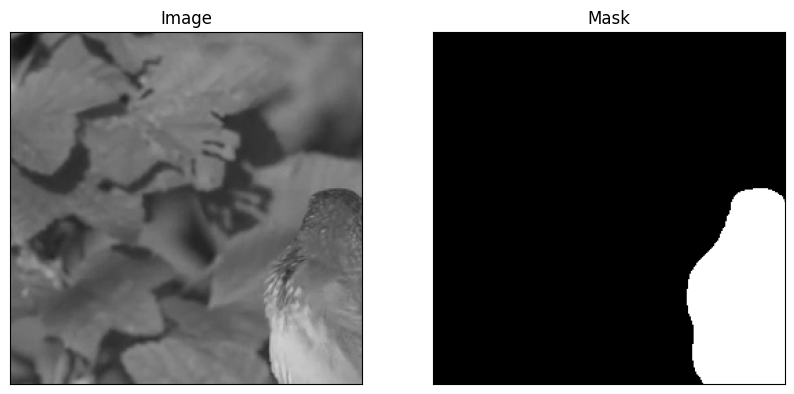

In [ ]:

img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(np.array(example_image), cmap='gray') 
axes[0].set_title("Image")

axes[1].imshow(example_mask, cmap='gray')  
axes[1].set_title("Mask")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()

In [ ]:

def get_bounding_box(ground_truth_map):

  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [ ]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])
    

    prompt = get_bounding_box(ground_truth_mask)

    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs



In [ ]:
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [31]:
processor


SamProcessor:
- image_processor: SamImageProcessor {
  "_valid_processor_keys": [
    "images",
    "segmentation_maps",
    "do_resize",
    "size",
    "mask_size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "do_pad",
    "pad_size",
    "mask_pad_size",
    "do_convert_rgb",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SamImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "mask_pad_size": {
    "height": 256,
    "width": 256
  },
  "mask_size": {
    "longest_edge": 256
  },
  "pad_size": {
    "height": 1024,
    "width": 1024
  },
  "processor_class": "SamProcessor",
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1024
  }
}


{
  "

In [ ]:
train_dataset = SAMDataset(dataset=train_dataset, processor=processor)

train_dataset


In [34]:
example = train_dataset[0]

for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [ ]:
from torch.utils.data import DataLoader


In [36]:
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)
len(train_dataloader)

6364

In [37]:

batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [38]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [ ]:
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [ ]:
from torch.optim import Adam
import monai

optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from sklearn.metrics import accuracy_score

num_epochs = 15

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    epoch_accuracies = []  
    for batch in tqdm(train_dataloader):

        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)


        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        epoch_losses.append(loss.item())

        predicted_labels = (predicted_masks > 0.7).float()
        ground_truth_labels = (ground_truth_masks > 0.7).float()
        accuracy = accuracy_score(ground_truth_labels.view(-1).cpu(), predicted_labels.view(-1).cpu())

        epoch_accuracies.append(accuracy)

    mean_accuracy = mean(epoch_accuracies)

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
    print(f'Mean accuracy: {mean_accuracy}')


100%|██████████| 6364/6364 [45:33<00:00,  2.33it/s]


EPOCH: 0
Mean loss: 0.1945944916359474
Mean accuracy: 0.9606624174088071


100%|██████████| 6364/6364 [45:26<00:00,  2.33it/s]


EPOCH: 1
Mean loss: 0.17307784864114098
Mean accuracy: 0.9651711665932148


100%|██████████| 6364/6364 [45:19<00:00,  2.34it/s]


EPOCH: 2
Mean loss: 0.16320670280932775
Mean accuracy: 0.9674545841948331


100%|██████████| 6364/6364 [44:51<00:00,  2.36it/s]


EPOCH: 3
Mean loss: 0.15658969740685671
Mean accuracy: 0.9687604382680992


100%|██████████| 6364/6364 [44:45<00:00,  2.37it/s]


EPOCH: 4
Mean loss: 0.1515312810672247
Mean accuracy: 0.9701519887601707


100%|██████████| 6364/6364 [44:44<00:00,  2.37it/s]


EPOCH: 5
Mean loss: 0.14636543834240115
Mean accuracy: 0.9713210616000864


100%|██████████| 6364/6364 [44:53<00:00,  2.36it/s]


EPOCH: 6
Mean loss: 0.1424358891601113
Mean accuracy: 0.9724430117795934


100%|██████████| 6364/6364 [44:33<00:00,  2.38it/s]


EPOCH: 7
Mean loss: 0.13992026254470624
Mean accuracy: 0.9730003400091702


100%|██████████| 6364/6364 [44:39<00:00,  2.37it/s]


EPOCH: 8
Mean loss: 0.13569415701059467
Mean accuracy: 0.974057198170219


100%|██████████| 6364/6364 [44:53<00:00,  2.36it/s]


EPOCH: 9
Mean loss: 0.13265597495584944
Mean accuracy: 0.974706193023624


100%|██████████| 6364/6364 [44:42<00:00,  2.37it/s]


EPOCH: 10
Mean loss: 0.1305115402644409
Mean accuracy: 0.9751645549148378


100%|██████████| 6364/6364 [44:48<00:00,  2.37it/s]


EPOCH: 11
Mean loss: 0.1284978212169673
Mean accuracy: 0.9756291963108525


100%|██████████| 6364/6364 [44:46<00:00,  2.37it/s]


EPOCH: 12
Mean loss: 0.12722463226043879
Mean accuracy: 0.975952128057282


100%|██████████| 6364/6364 [45:10<00:00,  2.35it/s]


EPOCH: 13
Mean loss: 0.12262842497299001
Mean accuracy: 0.9769316924435024


100%|██████████| 6364/6364 [44:48<00:00,  2.37it/s]

EPOCH: 14
Mean loss: 0.1222609977309149
Mean accuracy: 0.9770195000131201


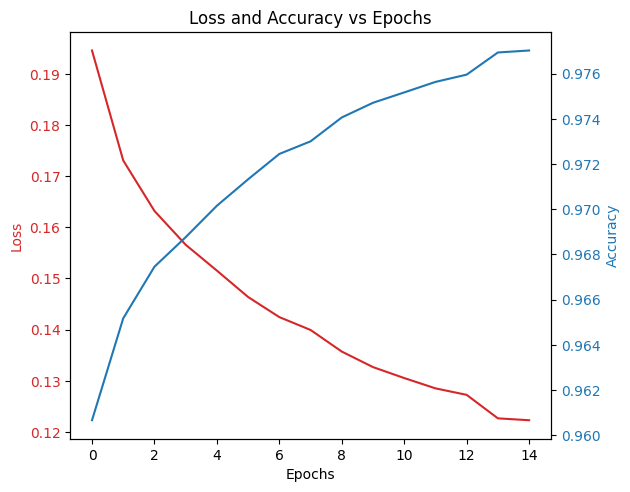

In [ ]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, epoch_losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  
ax2.plot(epochs, epoch_accuracies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Loss and Accuracy vs Epochs')
plt.show()

In [ ]:
torch.save(model.state_dict(), "/mnt/DD4To/Datasets/P2M/my_model")


In [42]:

from transformers import SamModel, SamConfig, SamProcessor
import torch

In [ ]:
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

my_mito_model = SamModel(config=model_config)

model_weights_path = "/mnt/DD4To/Datasets/P2M/my_model"
device = torch.device('cpu')  
my_mito_model.load_state_dict(torch.load(model_weights_path))

my_mito_model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)


SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [ ]:
import os
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

def calculate_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask)
    union = np.logical_or(pred_mask, true_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

output_directory = "predicted_masks_malek"
os.makedirs(output_directory, exist_ok=True)

iou_scores = []
losses = []

for idx in range(len(test_dataset)):
    test_image = test_dataset[idx]["image"]

    ground_truth_mask = np.array(test_dataset[idx]["label"])
    prompt = get_bounding_box(ground_truth_mask)

    inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = my_mito_model(**inputs, multimask_output=False)

    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

    output_filename = os.path.join(output_directory, f"predicted_mask_{idx}.png")
    plt.imsave(output_filename, medsam_seg, cmap='gray')


    iou = calculate_iou(medsam_seg, ground_truth_mask)
    iou_scores.append(iou)
    ground_truth_mask_tensor = torch.tensor(ground_truth_mask, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)
    loss = seg_loss(outputs.pred_masks.squeeze(1), ground_truth_mask_tensor)
    losses.append(loss.item())

average_iou = np.mean(iou_scores)
print(f"Average IoU: {average_iou}")
average_loss = np.mean(losses)
print(f"Average Loss: {average_loss}")


Average IoU: 0.8402120335335218
Average Loss: 0.15779942923977314
